# Example VAMML usage and workflow

## Overview
This notebook is designed to walk you through each step of using VAMML, from creation of experiment to use of trained model. This notebook uses a small amount of prepared data for example processing. Please be aware that later examples with tensorflow datasets require extensive C++ libraries to be installed for dependencies to run correctly.

## Starting a new printing experiment

To begin with, let's start by how to generate a new experiment. The Experiment module requires a directory name where it will create a directory structure for organization. It uses the lowest level as the experiment name (such as ```expt_001```). Generally, this package encourages unique experiment names for tracking, and for experiments to be stored in a base directory (eg ```expts/expt_001```), though subdirectories for organization are fine (eg ```expts/pegda/expt_001```). The directory tree will be automatically made without deleting existing files when Experiment is instantiated.

### Initializing the experiment

To start, let's load up the Experiment module and run it with default parameters. Metadata is also added to the file to lend experimental context for later recall.

Batch generated |████████████████████████████████████████| 1/1 [100%] in 1.1s (0.89/s) 


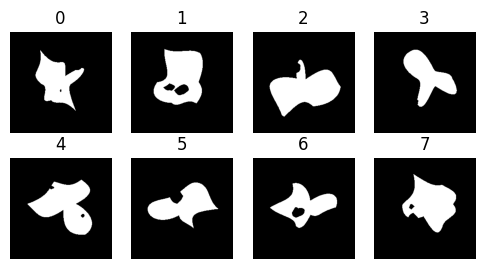

In [1]:
from vamml import Experiment
base_dir = 'tmp2/test5'
# Experiment is instantiated by specifying a base directory.
expt = Experiment(base_dir)
# Metadata can include any relevant variables in the experiment, added as a dictionary.
# Remember variable keys and values for consistency between experiments.
expt.metadata({
    "dose":150., # Light dose. For Tomolite, in mJ/cm^2
    "material": "GelMA", # Any mixed str and other values will be parsed as categorical later.
    "batch": "A",
    "concentration": 5., # If a value is numeric, try to use a float.
    })
expt.begin_expt()

Above is a plot of the set of generated shapes (indexing started from a pythonic index of 0). They've been cast into a voxel array as well, in the ```expt/arrays``` folder. They can be visualized in 2D with axial projections.

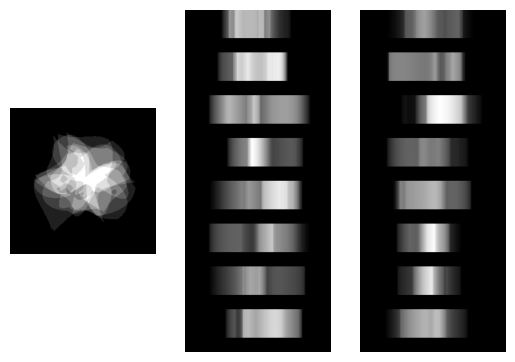

In [2]:
from vamml.utils.voxel_formats import import_tomolite
from matplotlib import pyplot as plt
import os
arr = import_tomolite(os.path.join(base_dir,'voxels'))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(arr.sum(axis=i),cmap='gray')
    plt.axis('off')

## After printing and imaging
Once the voxel array is prepared, it has to be printed and imaged. For this demonstration, several example images have been provided. Let's copy them into our test directory along with their base shapes to simulate a successful run. 

### Looking at the data

Let's take a look at the images to see the data we're working with.

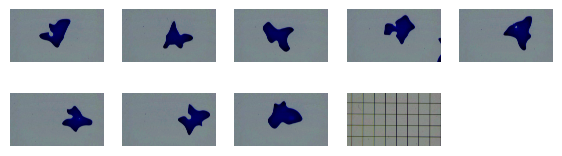

In [3]:
import shutil,os
from matplotlib import pyplot as plt
from PIL import Image
shutil.copytree('example',base_dir,dirs_exist_ok=True) # Copying data over.
src = os.path.join(base_dir,'images')
fig = plt.figure(figsize=(7,2))
for i,im in enumerate(os.listdir(src)):
    plt.subplot(2,5,i+1)
    plt.imshow(Image.open(os.path.join(src,im)))
    plt.axis('off')


Our imaging data includes eight imaged shapes (one for each generated, though multiple runs on the same template can be collated), as well as a calibration grid for auto-calibration. The scope used in this experiment had a variable zoom so a calibration image was included with each experiment, but if your scope has a fixed objective then you can supply a calibration value (in units/px) to Experiment during startup or processing (see wiki ***TODO).

### Processing and alignment
From here we can process the images to extract their features, and align the features with the base shapes to create training pairs. The default image processing method assumes a blue shape on a bright background. Other functions can be provided to the processing method to support other feature extraction pipelines (see wiki***TODO add link).

Processing images |████████████████████████████████████████| 8/8 [100%] in 12.6s (0.64/s) 
Aligning images |████████████████████████████████████████| 8/8 [100%] in 0.8s (10.37/s) 
Exporting data |████████████████████████████████████████| 8/8 [100%] in 1.7s (4.83/s) 


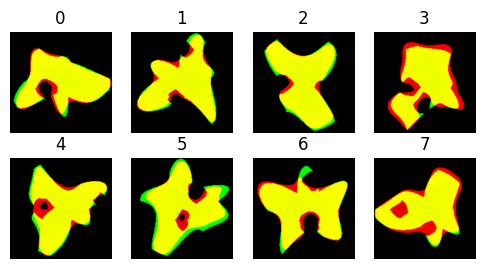

In [4]:
expt = Experiment(base_dir) # Re-initializing experiment for new data.
expt.complete_expt() 

Above we can see the outcomes of automated alignment, with image features shown in red while base shapes are in green (yellow is overlap). While everything processed correctly here, we can also manually correct any alignments.

### Manual alignment correction

Alignments can be manually corrected by selecting the image index to correct, the shape index to pair with, and rotation and mirror values. Since we used a different experiment's base, let's pull up the base shapes plot for our imported experiment.

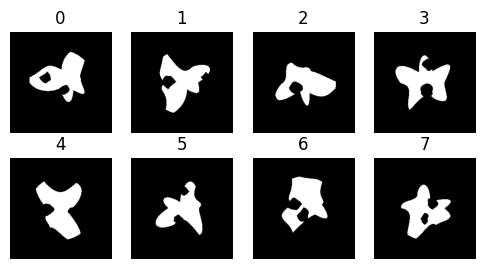

In [5]:
expt.plot_shapes()

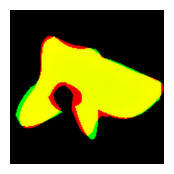

In [6]:
expt.correct_alignment(
    0, # Image feature to correct.
    2, # Matching base shape.
    138, # Rotation, arbitrary value so iterate as necessary.
    True # Mirroring, arbitrary value so iterate as necessary.
)

An experimental interactive plot feature is also available (see vamml.batchutils.experimental.correct_interactive). As of writing it's not yet stable, so use with care. 

## Collating experiments

Once enough experiments have been run to generate a significant body of data, we'll want to collate data across experiments to feed into a model. To start, let's make a dataset from experiments.

In [7]:
from vamml import collate_metadata
collate_metadata('tmp2') # Collating all experimental metadata and replicates nested within this dir.
# Loading with pandas to show data.
import pandas as pd
pd.read_csv('tmp2/metadata.csv').head()

,source,expt_index,base_image,array_size,batch,concentration,dose,expt,material,voxel_size,z_height
0,tmp2\test5\arrays\output.npy,0,tmp2\test5\images\1.png,256,A,5.0,150.0,test5,GelMA,0.025,0.650
1,tmp2\test5\arrays\output.npy,1,tmp2\test5\images\2.png,256,A,5.0,150.0,test5,GelMA,0.025,2.525
2,tmp2\test5\arrays\output.npy,2,tmp2\test5\images\3.png,256,A,5.0,150.0,test5,GelMA,0.025,4.400
3,tmp2\test5\arrays\output.npy,3,tmp2\test5\images\4.png,256,A,5.0,150.0,test5,GelMA,0.025,6.275
4,tmp2\test5\arrays\output.npy,4,tmp2\test5\images\5.png,256,A,5.0,150.0,test5,GelMA,0.025,8.150


Here we can see a collection of all metadata across experiments. From this we'll want to draw all of the metadata column names that we want to include in the experiment. If you have data you want to add later, you can load in an experiment key csv which reads the expt values and pairs them with additional metadata that you may not have included at the time you processed the Experiment (see wiki ###TODO). Don't worry about NaNs, as all non-numeric columns will be categorized with these taken into account as 0's.

This step is optional in relation to the next step, which will automatically run collate_metadata if none is provided.

## Making a dataset

Next we want to structure our data into a format which can most easily be fed into the model: a tensorflow dataset. 
This pipeline will always force "dose" to be included as the first value, even if it's empty, due to the augmentation stack. This should be run from the same base directory as metadata.csv was generated from, as this pipeline needs relative directory pointers to output arrays.

In [8]:
from vamml import make_dataset
df = make_dataset(
    # Like Experiment, the dataset name will be inferred from lowest level dir here.
    out_dir = 'tmp2/dataset1', 
    # Loading prepared csv. Can also be base_dir for collate_metadata to run in situ.
    metadata = 'tmp2/metadata.csv', 
    # Any metadata columns to include in parameters.
    metadata_cols = ['dose','voxel_size','z_height','batch','concentration','material'] 
)

Auto-detected splits:
 * train: 1 shards


Computed split infos: 
[<SplitInfo num_examples=8, num_shards=1>]
FeaturesDict({
    'image': Tensor(shape=(256, 256, 1), dtype=float32, description=Extracted feature from gel image),
    'label': Tensor(shape=(256, 256, 1), dtype=float32, description=Print array),
    'parameters': Tensor(shape=(6,), dtype=float32, description=Encoded experiment parameters: {'dose': 'float', 'voxel_size': 'float', 'z_height': 'float', 'batch': {'nan': 0, 'A': 1}, 'concentration': 'float', 'material': {'nan': 0, 'GelMA': 1}}),
})
Metadata written. Testing by reading first example. Set check_data=False to skip.


Note that in the 'parameters' description is a key for parameter order, types, and in the case of categoricals, dictionaries describing keys to numerical codes for later reconstruction of a float list.

## Training a model

Now that we have a dataset, we can make and train a new model. 

### Preparing dataset

To start, let's prepare the dataset. This involves:
- Loading the dataset.
- Splitting into training and test sets.
- Augmenting the training set.

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
# Loading builder
builder = tfds.builder_from_directory(builder_dir='./tmp2/dataset1/')
# Specifying random train and test splits.
train_ds,test_ds = builder.as_dataset(
    split = ['train[:80%]', 'train[80%:]'],
    shuffle_files = True,
    batch_size = 4, # Since our dataset is so small, we're using a smaller batch size
    # read_config = tfds.ReadConfig(shuffle_seed = 101),
    as_supervised = True,
)
from vamml import Augments
# Mapping augments to dataset to augment both voxel intensity and dose.
train_ds = train_ds.map(
    Augments(), # Instantiating Augments class.
    num_parallel_calls=tf.data.experimental.AUTOTUNE
).prefetch(tf.data.experimental.AUTOTUNE)
train_ds = train_ds.repeat()
test_ds = test_ds.repeat()


### Aside: Data augmentation

This pipeline uses a customized augmentation pipeline which inversely scales light dose and voxel intensity. This is designed to train the model to automatically scale voxel output appropriate to dose. This reduces the need to optimize light dose when printing with corrected arrays.

Let's pull a single element from our test_ds (so it's not pre-augmented) to visualize our augmentations. The Augments class can even be modified at instantiation with a Keras sequential layer defining a series of augmentations to perform.

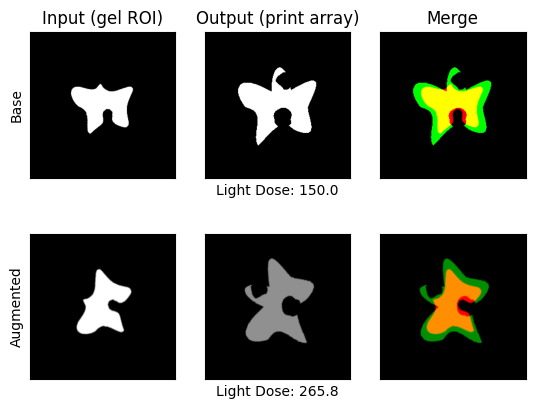

In [25]:
from matplotlib import pyplot as plt
import numpy as np
aug = Augments()
x = test_ds.take(1).get_single_element()
y = aug(x[0],x[1])
ims = [x[0][0][0],y[0][0][0],x[1][0][0],y[1][0][0]]
fig,axs = plt.subplots(2,3)
for ax in axs.flatten():
    ax.spines.set_visible=False
    ax.set_xticks([])
    ax.set_yticks([])
for i in range(4):
    axs[i%2][i//2].imshow(ims[i],vmin=0,vmax=1,cmap='gray')
axs[0][0].set_title('Input (gel ROI)')
axs[0][0].set_ylabel('Base')
axs[1][0].set_ylabel('Augmented')
axs[0][1].set_title('Output (print array)')
axs[0][1].set_xlabel(f'Light Dose: {float(x[0][1][0][0]):.1f}')
axs[1][1].set_xlabel(f'Light Dose: {float(y[0][1][0][0]):.1f}')
axs[0][2].imshow(np.concatenate([ims[0],ims[2],np.zeros_like(ims[0])],axis=-1))
axs[0][2].set_title('Merge')
axs[1][2].imshow(np.concatenate([ims[1],ims[3],np.zeros_like(ims[1])],axis=-1))

As we can see in the output column, the augmented array is dimmer, with a higher intensity dose. This will train the array to adjust output intensity relative to input dose.

### Training the model

Now let's instantiate and train the model. Since we have such a small dataset, we're not going to get much training power out of this short demonstration.

In [11]:
from vamml import build_model
# Explicitly loading in element specs for image and metadata sizes. Other parameters are available.
model = build_model(imageSize = train_ds.element_spec[0][0].shape[-3:],
                    metadataSize = train_ds.element_spec[0][1].shape[-1])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=10**-4),
              loss='mse',)
model.fit(train_ds, 
          validation_data=test_ds,
          steps_per_epoch=1, 
          epochs=10,
          validation_steps = 1,)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.2542 - val_loss: 0.2522
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.2293 - val_loss: 0.2520
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.2513 - val_loss: 0.2518
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.2511 - val_loss: 0.2516
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.2518 - val_loss: 0.2514
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.2291 - val_loss: 0.2512
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.2504 - val_loss: 0.2510
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.2480 - val_loss: 0.2508
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.2315 - val_loss: 0.2506
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.2227 - val_loss: 0.2504


If desired, these results can be concatenated with the VAMML experimental data (TODO add dataverse link and example).

Let's save the model for later use. 

In [34]:
model.export('tmp/model1')

INFO:tensorflow:Assets written to: tmp/model1\assets


INFO:tensorflow:Assets written to: tmp/model1\assets


Saved artifact at 'tmp/model1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='image'), TensorSpec(shape=(None, 6), dtype=tf.float32, name='metadata')]
Output Type:
  TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None)
Captures:
  2728495371024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2728495372176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2728495370832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2728495370256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2728495371600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2728495370640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2728495373520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2728495374672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2728495373712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2728495373136: TensorSpec(shape=(),